* By: Aaron Debrincat
* Email: aaron.deb.31@gmail.com
* Reference: __Enhancing a Pairs Trading strategy with the application of Machine Learning__ _by_ Simão Moraes Sarmento and Nuno Horta



# Implementation of a Machine Learning based Pairs Selection Framework

## Abstract

In this paper[1], Horta and Sarmento propose a two stage solution to applying machine learning to the problem of pairs trading. The first stage involves the application of a clustering algorithm to infer any meaningful clusters and using these groups to generate pairs that will be run through a selection process that will supply a list of pairs that comply with the conditions set. 

The second stage should start by training forecasting algorithms to predict the spreads of the selected pairs. Further more, decile-based and quintile-based thresholds should be collected to integrate the trading model. Having fitted the forecasting algorithms and obtained the two combinations for the thresholds, the model can be applied on the validation set. From the validation performance, the best threshold combination is selected. At this point, the model is finally ready to be applied on unseen data, from which the performance may be inferred.

## Introduction

This notebook will focus on the first stage, which refers to the pairs selection methodology. It will involve the application of PCA to distill the returns universe into a lower dimensional form. Then the OPTICS algorithm will be applied, on the expectation that it infers meaningful clusters of assets from which to select the pairs. The motivation is to let the data explicitly manifest itself, rather than manually defining the groups each security should belong to. The proposed methodology encompasses the following steps:

- Dimensionality reduction - find a compact representation for each security;
- Unsupervised Learning - apply an appropriate clustering algorithm;
- Select pairs - define a set of rules to select pairs for trading.


![image info](./images/prposed_framework_diagram.png)

---

# Example Usage of Implementation

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
from pairs_selector import PairsSelector

import warnings
warnings.filterwarnings('ignore')

In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
P_i = pd.read_csv('./data/data.csv').set_index('Date').dropna()
P_i.index = pd.to_datetime(P_i.index)

P_i = P_i.last('10Y')

P_i.sample(10)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-30,53.320000,42.540001,148.669998,35.982498,65.459999,89.139999,125.000000,44.549999,120.519997,129.610001,...,57.880001,83.699997,62.650002,29.520000,49.900002,64.019997,121.360001,89.559998,42.380001,53.470001
2019-04-26,77.419998,33.060001,170.190002,51.075001,79.699997,74.050003,274.910004,78.559998,180.830002,281.959991,...,118.930000,80.489998,50.900002,32.310001,83.110001,104.089996,123.860001,229.179993,48.750000,103.349998
2019-07-30,70.150002,30.709999,151.800003,52.195000,67.180000,88.720001,279.230011,88.309998,195.649994,303.640015,...,119.510002,75.349998,56.669998,32.779999,81.120003,113.239998,136.669998,218.199997,45.480000,115.790001
2019-10-17,74.919998,27.930000,163.750000,58.820000,75.139999,89.500000,176.520004,82.379997,186.039993,269.239990,...,94.910004,68.139999,54.950001,29.570000,78.809998,110.370003,138.509995,205.729996,44.040001,128.470001
2020-07-28,95.300003,11.770000,146.190002,93.252502,96.709999,102.110001,294.890015,99.860001,222.179993,432.260010,...,104.809998,43.549999,43.500000,15.210000,74.339996,92.750000,134.160004,271.179993,32.259998,145.979996
2016-12-23,46.200001,48.480000,170.889999,29.129999,62.340000,78.559998,112.379997,38.419998,117.480003,105.019997,...,60.560001,90.709999,59.240002,23.583662,51.009998,63.810001,102.320000,86.419998,43.860001,53.779999
2019-03-07,78.730003,32.220001,154.130005,43.125000,78.239998,76.330002,317.420013,76.800003,161.850006,255.460007,...,119.910004,80.160004,48.220001,30.240000,75.320000,96.540001,121.389999,201.990005,48.709999,92.550003
2017-05-05,56.639999,44.509998,144.979996,37.240002,66.989998,85.889999,133.029999,44.639999,121.519997,134.839996,...,63.389999,82.019997,65.589996,28.280001,52.299999,69.300003,116.540001,96.559998,40.750000,59.470001
2019-05-01,77.470001,33.910000,163.830002,52.630001,78.889999,73.389999,277.070007,78.739998,181.309998,283.350006,...,116.639999,78.669998,50.310001,33.259998,83.290001,101.940002,121.220001,205.119995,48.580002,101.790001


## Step 1 - Dimensionality Reduction

### Using PCA to find a compact representation for each security

- Extracts common underlying risk factors from securities’ returns;
- Produces a compact representation for each security;

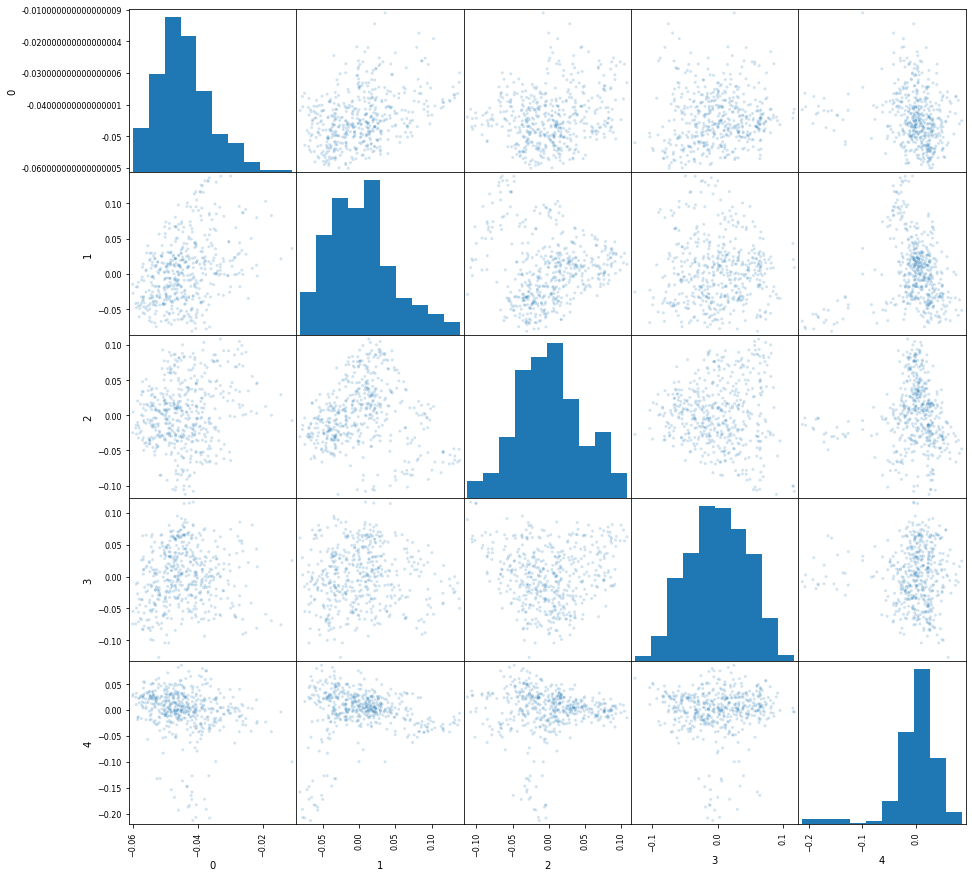

In [4]:
ps = PairsSelector(P_i)
ps.dimensionality_reduction(5)
ps.plot_pca_matrix()

## Step 2 - Unsupervised Learning
### Applying OPTICS clustering algorithm

- No need to specify the number of clusters in advance;
- Robust to outliers;
- Suitable for clusters with varying density

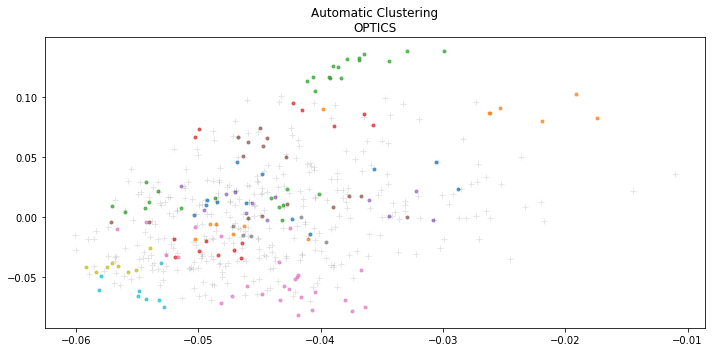

In [5]:
ps.cluster()
ps.plot_clustering_info()

## Step 3 - Select Pairs
### Finding resulting pairs that pass the following set of rules

- Cointegrated pairs - Finds sound equilibrium relationships;
- Mean-reverting Hurst exponent - Provides an extra layer of confidence to validate mean-reverting series;
- Suitable half-life - Filters out series with timings not compatible with the trading period;
- Monthly mean crossing - Filters out pairs for which the spread does not converge to its mean with enough regularity

2020-10-19 18:40:02.027374 100.0% _outer_cointegration_loop done after 2.05 minutes. Remaining 0.0 minutes.
2020-10-19 18:40:03.632527 100.0% _outer_ou_loop_light done after 0.01 minutes. Remaining 0.0 minutes.


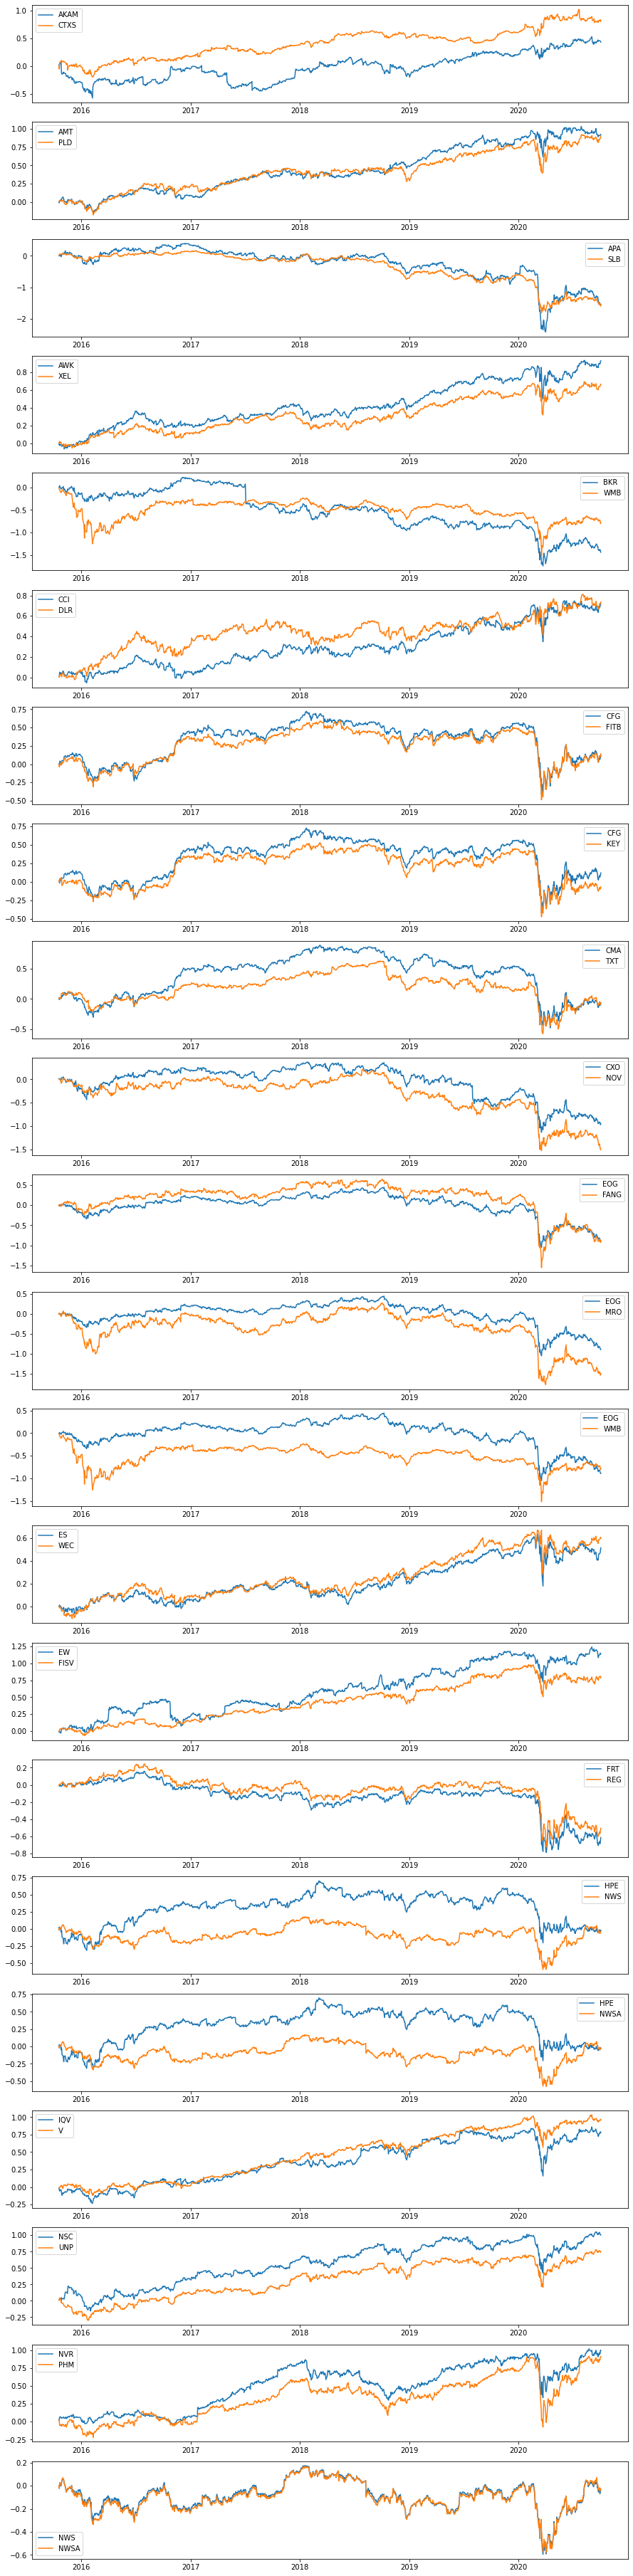

In [6]:
ps.criterion_selector()
ps.plot_selected_pairs()

In [7]:
ps.print_info()

,0,1
0,No. of Clusters,17
1,Total Pair Combinations,686
2,Pairs passing Coint Test,74
3,Pairs passing Hurst threshold,65
4,Pairs passing Half Life threshold,39
5,Final Set of Pairs,22


In [9]:
ps.final_pairs

[('AKAM', 'CTXS'),
 ('AMT', 'PLD'),
 ('APA', 'SLB'),
 ('AWK', 'XEL'),
 ('BKR', 'WMB'),
 ('CCI', 'DLR'),
 ('CFG', 'FITB'),
 ('CFG', 'KEY'),
 ('CMA', 'TXT'),
 ('CXO', 'NOV'),
 ('EOG', 'FANG'),
 ('EOG', 'MRO'),
 ('EOG', 'WMB'),
 ('ES', 'WEC'),
 ('EW', 'FISV'),
 ('FRT', 'REG'),
 ('HPE', 'NWS'),
 ('HPE', 'NWSA'),
 ('IQV', 'V'),
 ('NSC', 'UNP'),
 ('NVR', 'PHM'),
 ('NWS', 'NWSA')]

## Analysis of selected pairs sector/industry classifications

- ('AKAM', 'CTXS') - ('Internet - Services', 'Computer - Software')
- ('AMT', 'PLD') - ('REIT and Equity Trust - Other', 'REIT and Equity Trust - Other')
- ('APA', 'SLB') - ('Oil/Gas - Exploration and Production', 'Oil/Gas - Field Services')
- ('AWK', 'XEL') - ('Utility - Water Supply', 'Utility - Electric Power')
- ('BKR', 'WMB') - ('Oil/Gas - Field Services', 'Oil/Gas - Production and Pipelines')
- ('CCI', 'DLR') - ('REIT and Equity Trust - Other', 'REIT and Equity Trust - Other')
- ('CFG', 'FITB') - ('Financial - Savings and Loan', 'Banks - Major Regional')
- ('CFG', 'KEY') - ('Financial - Savings and Loan', 'Banks - Major Regional')
- ('CMA', 'TXT') - ('Banks - Major Regional', 'Aerospace - Defense')
- ('CXO', 'NOV') - ('Oil/Gas - Exploration and Production', 'Oil/Gas - Mechanical and and Equipment')
- ('EOG', 'FANG') - ('Oil/Gas - Exploration and Production', 'Oil/Gas - Exploration and Production')
- ('EOG', 'MRO') - ('Oil/Gas - Exploration and Production', 'Oil/Gas - Integrated')
- ('EOG', 'WMB') - ('Oil/Gas - Exploration and Production', 'Oil/Gas - Production and Pipelines')
- ('ES', 'WEC') - ('Utility - Electric Power', 'Utility - Electric Power')
- ('EW', 'FISV') - ('Medical - Instruments', 'Financial Transaction Services')
- ('FRT', 'REG') - ('REIT and Equity Trust - Retail', 'REIT and Equity Trust - Retail')
- ('HPE', 'NWS') - ('Computer - Integrated Systems', 'Film and Television Production and Distribution')
- ('HPE', 'NWSA') - ('Computer - Integrated Systems', 'Film and Television Production and Distribution')
- ('IQV', 'V') - ('Technology Services', 'Financial Transaction Services')
- ('NSC', 'UNP') - ('Transportation - Rail', 'Transportation - Rail')
- ('NVR', 'PHM') - ('Building Products - Home Builders', 'Building Products - Home Builders')
- ('NWS', 'NWSA') - ('Film and Television Production and Distribution', 'Film and Television Production and Distribution')

---

# Conclusion

This notebook describes the proposed Pairs Selection Framework also shows example usage of the implemented framework.

The major takeaway from the notebook is that, most of the final pairs selected follow expected economic sectoral clusters even though there was no implied industry/sectoral grouping anywhere in the framework.

# References
1. Sarmento, Simão. & Horta, Nuno. (2020). Enhancing a Pairs Trading strategy with the application of Machine Learning. Available at: http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf